# Overnight photometry recording analysis - single trial

This script will analyze and save data from a single long-term photometry recording, aligned to real circadian time. The photometry data is acquired from 2 channels: channel 1=neural recording (e.g. GCaMP); channel 2="control" channel (e.g. isosbestic) used to correct for movement artifacts.

The photometry file (acquired from pyPhotometry board) must be saved as a raw .ppd file, in its own directory with no other .ppd files. The photometry file name by default begins with the MouseID - this MouseID must begin with the letter 'A'.

This folder should also contain two .txt files:

1) 'StartTime.txt' - the circadian time at which the recording started, in 24h clock (format: HHMMSS). Assumes a 06.00-18.00 light cycle.

2) 'Cond.txt' - the condition being recorded. This can include, but is not limited to:

`6pm-8am fast` / `3pm-8am fast` / `12pm-8am fast`

`fed`

`6pm-8am water dep`

`6-8 fast Saline` / `6-8 fast CNO`

other pre-defined conditions are outlined below, but any condition name can be entered. In downstream analysis, this trial will be combined with other trials of the same condition name.

In [409]:
## open file and plot raw data
import os
from os import listdir
from os.path import isfile, join
from functions.data_import import import_ppd #in "functions" folder
from tkinter.filedialog import askopenfilename
from tkinter import Tk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize
from statistics import mean
import time
import datetime
from datetime import timedelta
from functions.date_range import date_range #in functions folder
from matplotlib.dates import DateFormatter
import pickle

################################################# 
# Set the following parameters:
DownSampleTo = 1 # rate to which to downsample
StartFrom_Input = 12 # time to start plot in 24h clock
EndAt_Input = 11 # time to end plot in 24h clock
LastDay = 2 # last day of recording
MMWindow1_Input = 30 # window for moving mean in minutes
MMWindow2_Input = 60 # window for second moving mean in minutes
F0Window_Input = 3 # window for F0, from t=1h after start, in hours
AllowNegCorr = 0 # should you allow correlation for correction to be <0? 0=No, 1=Yes
################################################# 

# note name of analysis file
AnalysisFile = 'Single_Overnight_Analysis'

plt.rcParams['figure.figsize'] = [9,10.5] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.

# Open a dialog box to select the photometry file to be analyzed
window = Tk()
window.wm_attributes('-topmost', 1)
window.withdraw()
PhotometryFile = askopenfilename(parent = window,
filetypes= (("ppd files","*.ppd"),("all files","*.*")))
# Import data from this file
data = import_ppd(PhotometryFile, None, None)
# Set directory to this folder
Dir=PhotometryFile[0:PhotometryFile.rfind('A')]
os.chdir(Dir)

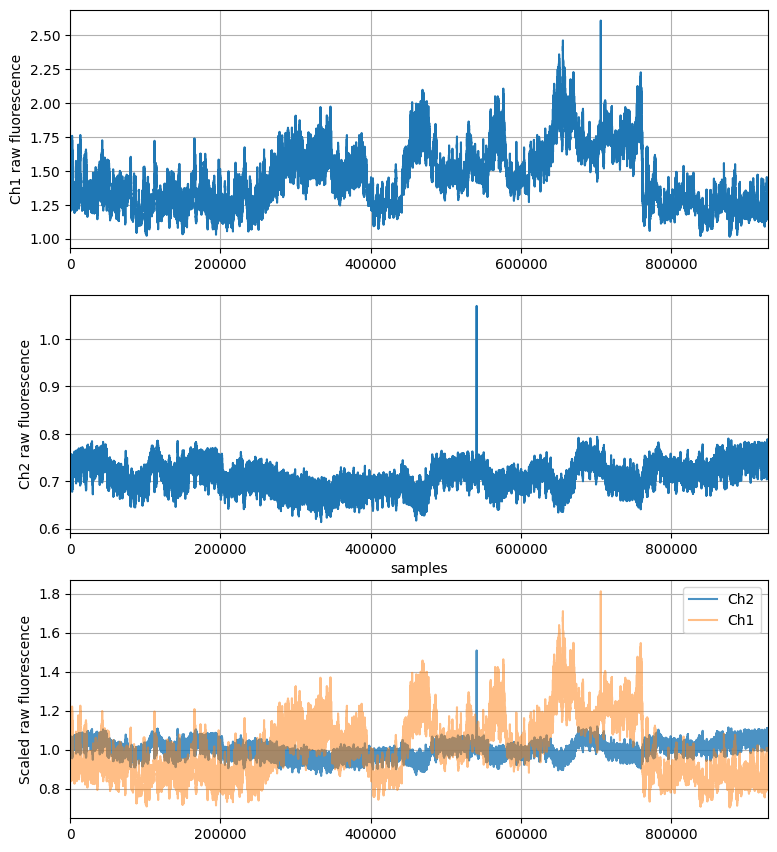

In [410]:
# Open Cond file and set condition name
f = open(Dir + 'Cond.txt', 'r')
CondName = f.readlines()[0]
# Set event times (in zeitgeber time) to mark based on condition (if one of the pre-existing defined conditions)
if CondName == "6pm-8am fast":
    EventDays = [1,2,2]
    EventTimes = [12,0,2]
    EventLabels = ['LightsOff-RemoveFood','LightsOn','ReplaceFood']
elif CondName == "fed":
    EventDays = [1,2]
    EventTimes = [12,0]
    EventLabels = ['LightsOff','LightsOn']
elif CondName == "3pm-8am fast":
    EventDays = [1,1,2,2]
    EventTimes = [9,12,0,2]
    EventLabels = ['RemoveFood','LightsOff','LightsOn','ReplaceFood']
elif CondName == "12pm-8am fast":
    EventDays = [1,1,2,2]
    EventTimes = [6,12,0,2]
    EventLabels = ['RemoveFood','LightsOff','LightsOn','ReplaceFood']
elif CondName == "6pm-8am marbles":
    EventDays = [1,2,2]
    EventTimes = [12,0,2]
    EventLabels = ['LightsOff-RemoveMarbles','LightsOn','ReplaceMarbles']
elif CondName == "6pm-8am water dep":
    EventDays = [1,2,2]
    EventTimes = [12,0,2]
    EventLabels = ['LightsOff-RemoveWater','LightsOn','ReplaceWater']
elif CondName == "ScheduledFeeding":
    EventDays = [1,1,1,2,2,2,2,3,3,3,3,3,4]
    EventTimes = [4,7,12,0,4,7,12,0,4,7,10,12,0]
    EventLabels = ['Food','FoodRemoved','LightsOff','LightsOn','Food','FoodRemoved','LightsOff','LightsOn','FoodOmitted','Food','FoodRemoved','LightsOff','LightsOn']
elif CondName == "choc ad lib":
    EventDays = [1,2]
    EventTimes = [12,0]
    EventLabels = ['LightsOff','LightsOn']
elif CondName == "choc 6pm fast":
    EventDays = [1,2]
    EventTimes = [12,0]
    EventLabels = ['LightsOff-Remove food','LightsOn']
elif CondName == "choc 6pm calorie-free":
    EventDays = [1,2]
    EventTimes = [12,0]
    EventLabels = ['LightsOff-Replace food with calorie-free','LightsOn']

elif CondName == "AdLib-Fast-Refeed":
    EventDays = [1,2,2,3,3,4]
    EventTimes = [12,0,12,0,12,0]
    EventLabels = ['LightsOff','LightsOn','LightsOff-FoodRemoved','LightsOn','LightsOff-FoodReplaced','LightsOn']
elif CondName == "6-8 fast Saline" or "FR1 6-8 fast Saline":
    EventDays = [1,2,2]
    EventTimes = [12,0,2]
    EventLabels = ['LightsOff-RemoveFood_Saline','LightsOn','ReplaceFood']
elif CondName == "6-8 fast CNO" or "FR1 6-8 fast CNO":
    EventDays = [1,2,2]
    EventTimes = [12,0,2]
    EventLabels = ['LightsOff-RemoveFood_CNO','LightsOn','ReplaceFood']
elif CondName == "6-8 fast 2h delay":
    EventDays = [1,1,2,2]
    EventTimes = [12,14,0,2]
    EventLabels = ['RemoveFood','LightsOff','LightsOn','ReplaceFood']
elif CondName == "sham fast":
    EventDays = [1,2,2]
    EventTimes = [12,0,2]
    EventLabels = ['LightsOff-ShamRemoval','LightsOn','ShamReplacement']
elif CondName == "FR1 6-8 fast" or "FR8 6-8 fast":
    EventDays = [1,2,2]
    EventTimes = [12,0,2]
    EventLabels = ['LightsOff-RemoveFood','LightsOn','ReplaceFood']
elif CondName == "FR1 fed" or "FR8 fed":
    EventDays = [1,2]
    EventTimes = [12,0]
    EventLabels = ['LightsOff','LightsOn']
elif CondName == "MET fast" or "MIFE fast" or "Veh fast":
    EventDays = [1,1,2]
    EventTimes = [10,12,0]
    EventLabels = ['Injection','LightsOff-RemoveFood','LightsOn']
else:
    EventDays = []
    EventTimes = []
    EventLabels = []

# No filtering at this stage!
# Now plot channels 1 and 2 on subplots
fig, axs = plt.subplots(3, 1)
axs[0].plot(range(len(data['analog_1'])),data['analog_1'])
axs[0].set_ylabel('Ch1 raw fluorescence')
axs[0].grid(True)

axs[1].plot(range(len(data['analog_2'])),data['analog_2'])
axs[1].set_xlabel('samples')
axs[1].set_ylabel('Ch2 raw fluorescence')
axs[1].grid(True)

# And plot the two channels on the same axes by scaling each to its mean
Ch1_Scaled=data['analog_1']/mean(data['analog_1'])
Ch2_Scaled=data['analog_2']/mean(data['analog_2'])

axs[2].plot(range(len(data['analog_2'])),Ch2_Scaled,alpha=0.8,label='Ch2')
axs[2].plot(range(len(data['analog_1'])),Ch1_Scaled,alpha=0.5,label='Ch1')
axs[2].set_ylabel('Scaled raw fluorescence')
axs[2].grid(True)
axs[2].legend(loc="upper right")

# Save this plot
fig.savefig('raw traces.png')

The recording from channel 2 is (largely) unaffected by neural activity, but contains any motion or bleaching artifacts that would be present in channel 1.
Therefore, we can use the channel 2 recording to predict the activity in channel 1 (using a linear regression model), and subtract this prediction from the actual channel 1 recording.
Any residual, unpredicted signals are likely non-artifactual, and thus due to neural activity.

One important note: there is a weak but significant negative correlation between channel 2 (isosbestic) signal and neural activity. Therefore, if the linear regression finds a negative coefficient, then there are no significant artifacts and we should not use this for correction. If the regression coefficient is positive, we will use this to predict the channel 1 activity and correct for artifacts as described above.

Slope    : -3.535
R-squared: 0.177


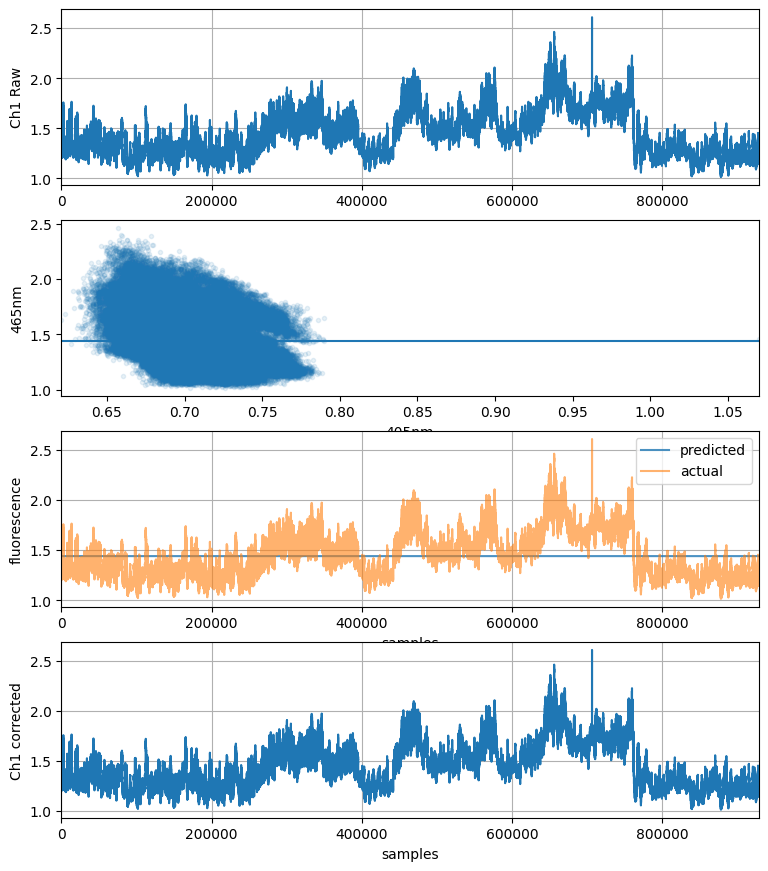

In [411]:
# Build linear regression model
slope, intercept, r_value, p_value, std_err = linregress(x=data['analog_2'], y=data['analog_1'])
# Print coefficient and R[2] values
print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))

# Disregard the coefficient if it is negative
if slope<0:
    slope = 0
    intercept = mean(data['analog_1'])

# Calculate estimated motion component of GCaMP signal using this linear regression model
GCaMP_est_motion = intercept + (slope * data['analog_2'])
GCaMP_est_mean = mean(GCaMP_est_motion)
GCaMP_corrected = data['analog_1'] - GCaMP_est_motion
GCaMP_corrected = GCaMP_corrected + GCaMP_est_mean

# Plot channel 1 signal before correction
fig, axs = plt.subplots(4, 1)
axs[0].plot(range(len(data['analog_1'])),data['analog_1'])
axs[0].set_ylabel('Ch1 Raw')
axs[0].grid(True)

# Scatter plot of channel 1 vs channel 2 activity at each time point
axs[1].scatter(data['analog_2'][::5], data['analog_1'][::5],alpha=0.1, marker='.')
# And regression line
x = np.array(axs[1].get_xlim())
axs[1].plot(x, intercept+slope*x)
axs[1].set_xlabel('405nm')
axs[1].set_ylabel('465nm')

# Plot predicted activity vs actual signal on same axes
axs[2].plot(range(len(GCaMP_est_motion)),GCaMP_est_motion,alpha=0.8,label='predicted')
axs[2].plot(range(len(data['analog_1'])),data['analog_1'],alpha=0.6,label='actual')
axs[2].set_xlabel('samples')
axs[2].set_ylabel('fluorescence')
axs[2].grid(True)
axs[2].legend(loc="upper right")

# Plot corrected activity (actual - predicted)
axs[3].plot(range(len(GCaMP_corrected)),GCaMP_corrected)
axs[3].set_xlabel('samples')
axs[3].set_ylabel('Ch1 corrected')
axs[3].grid(True)

# Save figure
fig.savefig('correction.png')
del(GCaMP_est_motion, GCaMP_est_mean)

Next, scale data using dF/F0. F0 is calculated as the mean of activity within a specific period (specified above) from the beginning of the trial. dF/F0 is calculated for each timepoint F using (F-F0)/F0. Do this for both the corrected signal, and the raw Ch1 and Ch2 signals.

In addition, take z-score of dF/F0 (i.e. scale data to its variance). This is done by dividing dF/F0 by the standard deviation in the F0 period.

In [412]:
# Save raw traces (GCaMP,Ch1,Ch2) with timestamps to dict
Raw_df = pd.DataFrame({'GCaMP' : GCaMP_corrected, 'Ch1' : data['analog_1'], 'Ch2' : data['analog_2']})

# Downsample to make computation easier
DownSampleRate = int(data['sampling_rate']/DownSampleTo)
Raw_DS_df = pd.DataFrame({'GCaMP' : GCaMP_corrected[list(range(0,len(GCaMP_corrected)-1,DownSampleRate))],
                            'Ch1' : data['analog_1'][list(range(0,len(data['analog_1'])-1,DownSampleRate))],
                            'Ch2' : data['analog_2'][list(range(0,len(data['analog_2'])-1,DownSampleRate))]})

# Convert times for analysis to datetime format, and convert to Zeitgeber Time (lights on = ZT0) by subtracting 6h
StartFrom = datetime.datetime(1,1,1,StartFrom_Input - 6,0,0)
EndAt = datetime.datetime(1,1,LastDay,EndAt_Input - 6,0,0)
F0Window = StartFrom + timedelta(hours = F0Window_Input+1)

# Get the recording start time from StartTime file, convert to ZT (-6h), and calculate end time (for the raw and downsampled data)
f = open(Dir + 'StartTime.txt', 'r')
StartTime = f.readlines()
StartTime = datetime.datetime(1,1,1,int(StartTime[0][0:2])-6,int(StartTime[0][2:4]),int(StartTime[0][4:]))
EndTime = StartTime + datetime.timedelta(seconds=(len(Raw_DS_df['GCaMP'])-1)/DownSampleTo)
RawEndTime = StartTime + datetime.timedelta(seconds=(len(GCaMP_corrected)-1)/data['sampling_rate'])

# Get the timestamp for every time point
RawTimeRange = date_range(StartTime, RawEndTime, 1/data['sampling_rate'], 'seconds')
TimeRange = date_range(StartTime, EndTime, 1/DownSampleTo, 'seconds')
# Generate timestamps for the clipped range for analysis
ClipRange = date_range(StartFrom, EndAt, 1/DownSampleTo, 'seconds')

# Add timestamps to dataframes
Raw_df.index = RawTimeRange
Raw_DS_df.index = TimeRange

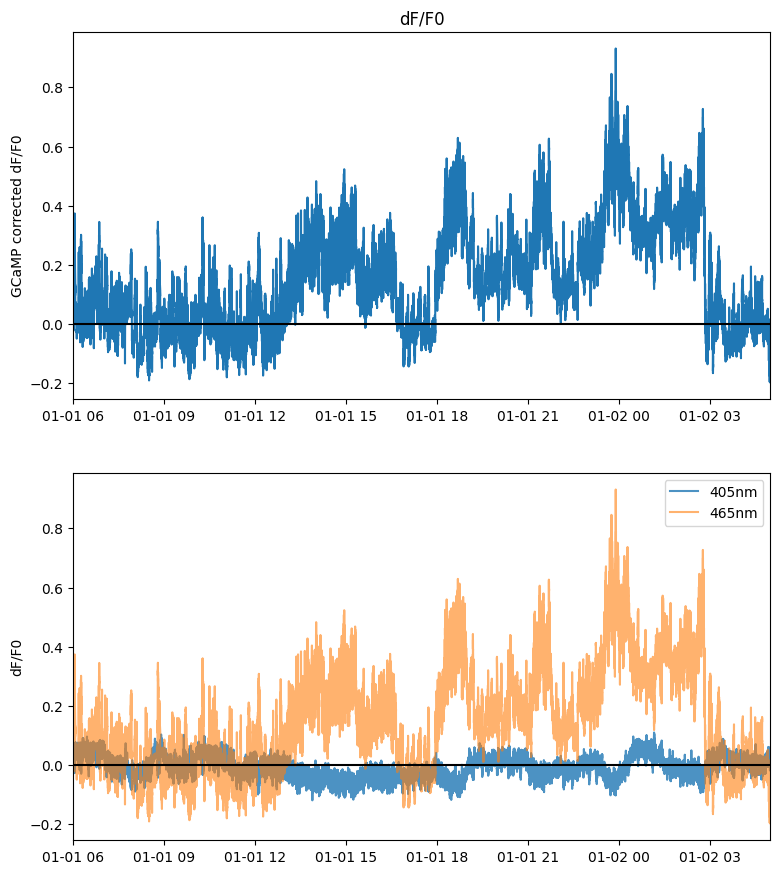

In [413]:
### Calculate dF/F0
# Calculate F0 from clip start to time set above
F0 = np.mean(Raw_DS_df.loc[StartFrom+timedelta(hours=1):F0Window], axis=0)

# Calculate standard deviation from clip start to time set above
stdF = np.std(Raw_DS_df.loc[StartFrom+timedelta(hours=1):F0Window], axis=0)

# Calculate dFF0 and clip trace
dFF0 = (Raw_DS_df.loc[StartFrom:EndAt] - F0) / F0

# Plot dF/F0 for corrected trace (upper) and raw Ch1 & Ch2 traces (lower)
fig, axs = plt.subplots(2, 1)
axs[0].plot(dFF0['GCaMP'])
axs[0].set_ylabel('GCaMP corrected dF/F0')
axs[0].axhline(y=0, color='k', linestyle='-') #plot horizontal line at y=0
axs[1].plot(dFF0['Ch2'],alpha=0.8,label='405nm')
axs[1].plot(dFF0['Ch1'],alpha=0.6,label='465nm')
axs[1].axhline(y=0, color='k', linestyle='-') #plot horizontal line at y=0
axs[1].set_ylabel('dF/F0')
axs[1].legend(loc="upper right")
axs[0].set_title('dF/F0')
fig.savefig('dFF0.png')

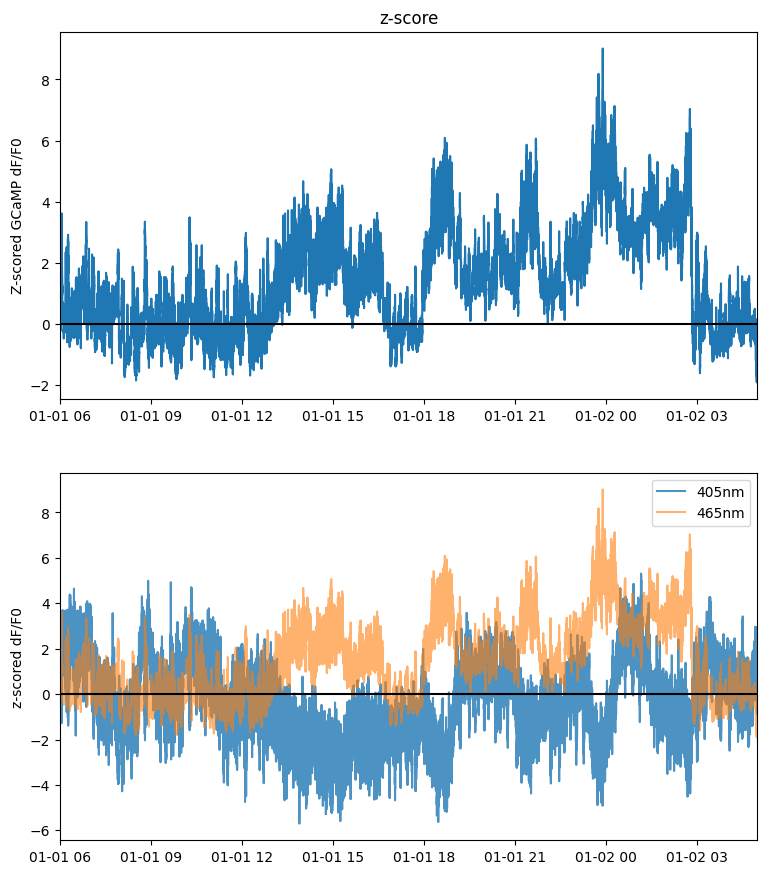

In [414]:
## Now calculate z-scored dF/F0
ZS = dFF0 / stdF

# Plot z-scored dF/F0 for corrected (upper) and raw (lower) traces
fig, axs = plt.subplots(2, 1)
axs[0].plot(ZS['GCaMP'])
axs[0].set_ylabel('Z-scored GCaMP dF/F0')
axs[0].axhline(y=0, color='k', linestyle='-') #plot horizontal line at y=0
axs[1].plot(ZS['Ch2'],alpha=0.8,label='405nm')
axs[1].plot(ZS['Ch1'],alpha=0.6,label='465nm')
axs[1].axhline(y=0, color='k', linestyle='-') #plot horizontal line at y=0
axs[1].set_ylabel('z-scored dF/F0')
axs[1].legend(loc="upper right")
axs[0].set_title('z-score')
fig.savefig('Zscore.png')

We are looking for relatively slow (minutes) fluctuations in signal. Therefore, we will take a moving mean to smooth out faster-timescale activity changes and noise. We will use several windows (defined below) to get a sense of what the data looks like.

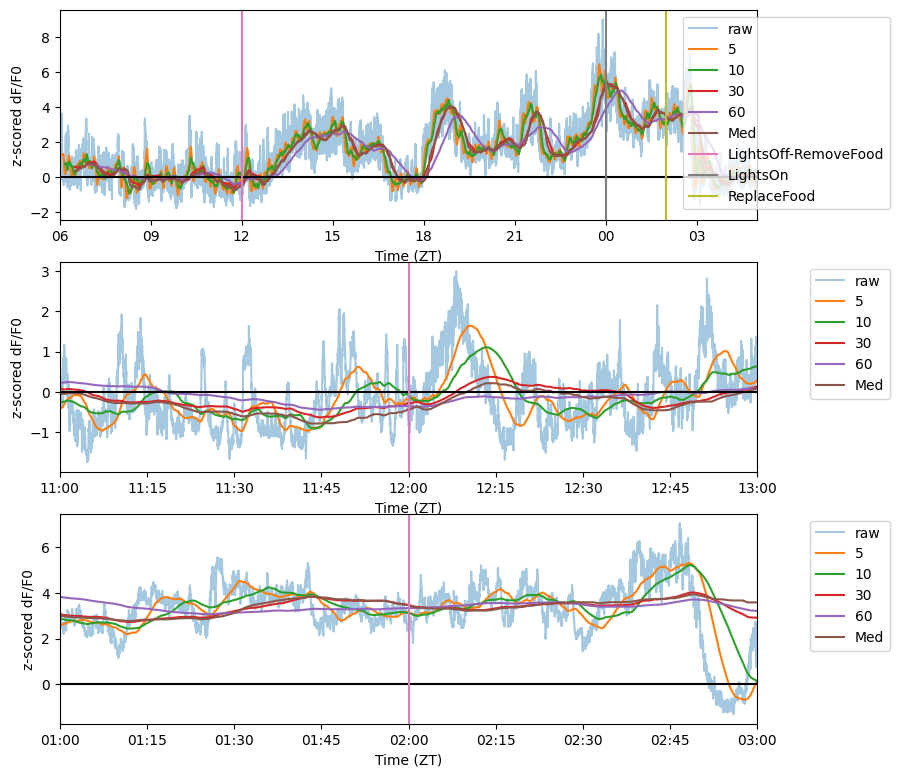

In [415]:
# Calculate moving means
windows = [5,10,30,60] #all window sizes to try (mins)

MM = pd.DataFrame(index = ZS.index)
for i in windows:
    MM[str(i)] = ZS['GCaMP'].rolling(window = 60*i*DownSampleTo, center = False).mean()

# Also calculate moving median with a window size of 30 mins
MM['Med'] = ZS['GCaMP'].rolling(window=30*60*DownSampleTo, center = False).median()

# Plot "raw" z-score and moving means/median
fig, axs = plt.subplots(3, 1)
axs[0].plot(ZS['GCaMP'], label='raw', alpha=0.4)
MM.plot(ax = axs[0])
axs[0].axhline(y=0, color='k', linestyle='-') #plot horizontal line at y=0
# plot vertical line at times of events of interest
ylim=axs[0].get_ylim()
for i in list(range(0,len(EventDays))):
    axs[0].plot([datetime.datetime(1,1,EventDays[i],EventTimes[i],0,0),datetime.datetime(1,1,EventDays[i],EventTimes[i],0,0)],ylim,label=EventLabels[i])
axs[0].set_ylim(ylim)
axs[0].legend(bbox_to_anchor=(1.2, 1), loc='upper right')
# change x tick labels to just show hours (not days)
date_form = DateFormatter("%H")
axs[0].xaxis.set_major_formatter(date_form)

# Plot just the time around lights-off (ZT11-13)
From = datetime.datetime(1,1,1,11,0,0)
To = From + datetime.timedelta(seconds=60*60*2)
axs[1].plot(ZS['GCaMP'][From:To], label='raw', alpha=0.4)
MM[From:To].plot(ax = axs[1])
axs[1].axhline(y=0, color='k', linestyle='-') #plot horizontal line at y=0
#plot vertical line at ZT12
ylim = axs[1].get_ylim()
axs[1].plot([datetime.datetime(1,1,1,12,0,0),datetime.datetime(1,1,1,12,0,0)],ylim)
axs[1].set_ylim(ylim)
axs[1].set_ylabel('z-scored dF/F0')
axs[1].legend(bbox_to_anchor=(1.2, 1), loc='upper right')
# change x tick labels to just show hours (not days)
date_form = DateFormatter("%H:%M")
axs[1].xaxis.set_major_formatter(date_form)

# Plot just the time around ZT2
From = datetime.datetime(1,1,2,1,0,0)
To = From + datetime.timedelta(seconds=60*60*2)
axs[2].plot(ZS['GCaMP'][From:To], label='raw', alpha=0.4)
MM[From:To].plot(ax = axs[2])
axs[2].axhline(y=0, color='k', linestyle='-') #plot horizontal line at y=0
#plot vertical line at ZT2
ylim = axs[2].get_ylim()
axs[2].plot([datetime.datetime(1,1,2,2,0,0),datetime.datetime(1,1,2,2,0,0)],ylim)
axs[2].set_ylim(ylim)
axs[2].set_ylabel('z-scored dF/F0')
axs[2].legend(bbox_to_anchor=(1.2, 1), loc='upper right')
# change x tick labels to just show hours (not days)
axs[2].xaxis.set_major_formatter(date_form)

for ax in axs:
    ax.set_xticks(ax.get_xticks()) #to suppress FixedLocator warning
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, ha = 'center') #by default matplotlib rotates and right-aligns datetime labels
    ax.set(xlabel = 'Time (ZT)', ylabel = 'z-scored dF/F0')
    
# save this figure
fig.savefig('Different_Moving_Means.png')

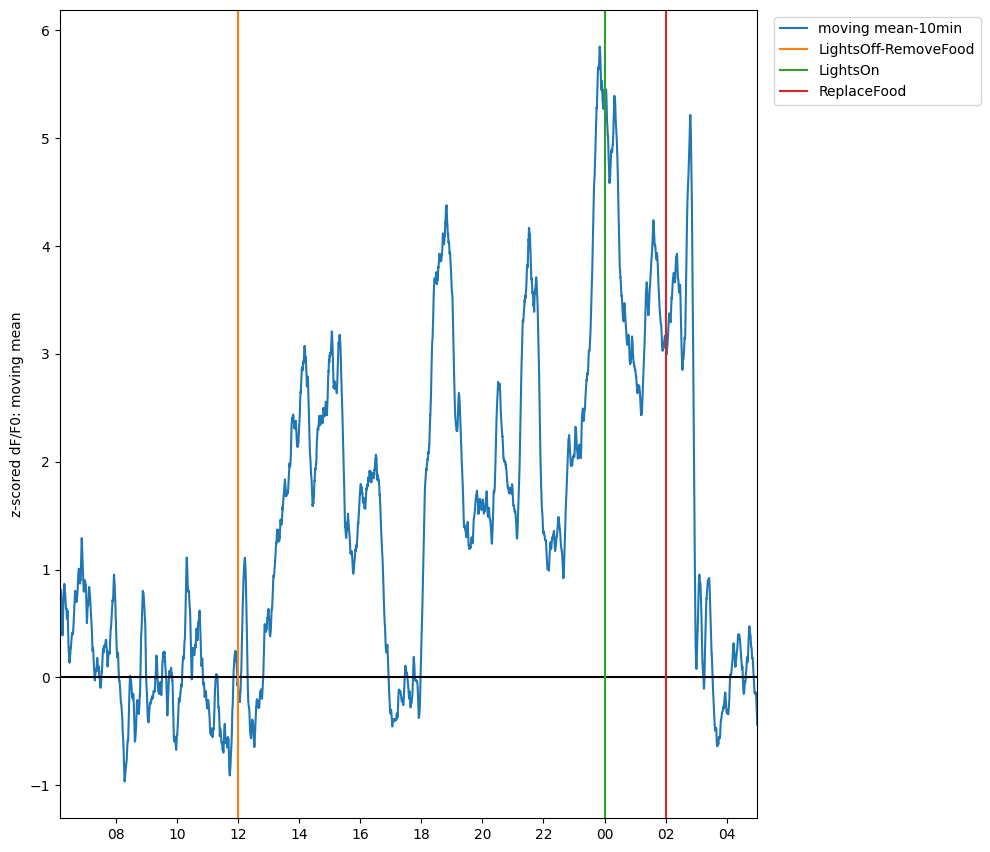

In [416]:
# Plot just one window size to make it easier to visualize
wind = 10 # window size to plot
fig, ax = plt.subplots(1, 1)
ax.plot(MM[str(wind)], label='moving mean-'+str(wind)+'min')
ax.axhline(y=0, color='k', linestyle='-') #plot horizontal line at y=0
ax.set_ylabel('z-scored dF/F0: moving mean')
ylim=ax.get_ylim()
for i in list(range(0,len(EventDays))):
    ax.plot([datetime.datetime(1,1,EventDays[i],EventTimes[i],0,0),datetime.datetime(1,1,EventDays[i],EventTimes[i],0,0)],
    ylim,label=EventLabels[i])
ax.set_ylim(ylim)
ax.legend(bbox_to_anchor=(1.33, 1), loc='upper right')
# change x tick labels to just show hours (not days)
date_form = DateFormatter("%H")
ax.xaxis.set_major_formatter(date_form)
ax.set_xticks(ax.get_xticks()) #to suppress FixedLocator warning
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, ha = 'center')

fig.savefig('MovingMean_'+str(wind)+'min.png')

Finally, save these data to a .pkl file

In [417]:
# First get event times & labels into dataframe
EventDateTimes = []
for i in list(range(0,len(EventDays))):
    EventDateTimes.append(datetime.datetime(1,1,EventDays[i],EventTimes[i],0,0))
Events = pd.DataFrame(data=EventLabels, index=EventDateTimes)

# Then get all data together into one dict
AllData = {'Raw' : Raw_df, 'Raw_DS' : Raw_DS_df, 'dFF0' : dFF0, 'z-score' : ZS, 'moving mean' : MM, 
            'Condition' : CondName, 'StartTime' : StartTime, 'Events' : Events, 'AnalysisFile' : AnalysisFile, 
            'SamplingRate' : data['sampling_rate'], 'DownSamplingRate' : DownSampleTo}

# And save to file
f = open('Data_' + PhotometryFile[PhotometryFile.rfind('A'):PhotometryFile.rfind('.')] + '.pkl',"wb")
pickle.dump(AllData,f)
f.close()